# Facial Expression Recognition | VGG19 Model - FER2013 Dataset

## Library

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Extract data from dataset and rehshape data back to 2D dimension

In [2]:
df = pd.read_csv('/kaggle/input/fer-2013/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [4]:
img_array.shape

(35887, 48, 48)

## Convert Data to RBG (to compatiable with VGG 19), also normalization using Min Max Scale

In [5]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

img_features = img_features/255

(35887, 48, 48, 3)


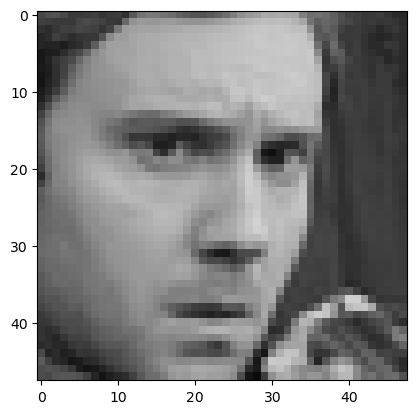

In [6]:
pyplot.imshow((img_features[0]*255).astype(np.uint8));

In [7]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [8]:
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)

### Splitting the data into training and validation set.

In [9]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                      y_train_valid, 
                                                      shuffle = True, 
                                                      stratify = y_train_valid, 
                                                      test_size = 0.11, 
                                                      random_state = 42)
X_train.shape, X_valid.shape,X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((28745, 48, 48, 3),
 (3553, 48, 48, 3),
 (3589, 48, 48, 3),
 (28745, 7),
 (3553, 7),
 (3589, 7))

In [10]:
# X_train,X_valid, y_train, y_valid = train_test_split(img_features, 
#                                                       img_labels, 
#                                                       shuffle = True, 
#                                                       stratify = img_labels, 
#                                                       test_size = 0.1, 
#                                                       random_state = 42)


In [11]:
# del df
# del img_features
# del img_labels

In [12]:
vgg = tf.keras.applications.VGG19(weights = "imagenet",
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [13]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [14]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalMaxPooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [15]:
num_classes = 7
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [16]:
# Freeze layers up to block1_pool
for layer in model.layers:
    layer.trainable = True
for layer in model.layers[:12]:
    layer.trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
global_max_pooling2d True
out_layer True


### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [17]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [18]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [19]:
def focal_loss(gamma=2):
    def loss(y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.math.exp(-ce_loss)
        focal_loss = tf.pow(1 - pt, gamma) * ce_loss
        return focal_loss
    return loss
gamma = 5

In [20]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 60
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])


In [21]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,

                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/60
898/898 [==============================] - 78s 75ms/step - loss: 1.5390 - accuracy: 0.4001 - val_loss: 1.3957 - val_accuracy: 0.4771 - lr: 1.0000e-04
Epoch 2/60
898/898 [==============================] - 65s 72ms/step - loss: 1.3502 - accuracy: 0.4845 - val_loss: 1.2959 - val_accuracy: 0.5069 - lr: 1.0000e-04
Epoch 3/60
898/898 [==============================] - 63s 70ms/step - loss: 1.2773 - accuracy: 0.5139 - val_loss: 1.2605 - val_accuracy: 0.5151 - lr: 1.0000e-04
Epoch 4/60
898/898 [==============================] - 68s 75ms/step - loss: 1.2248 - accuracy: 0.5353 - val_loss: 1.2009 - val_accuracy: 0.5432 - lr: 1.0000e-04
Epoch 5/60
898/898 [==============================] - 67s 74ms/step - loss: 1.1812 - accuracy: 0.5521 - val_loss: 1.1619 - val_accuracy: 0.5621 - lr: 1.0000e-04
Epoch 6/60
898/898 [==============================] - 67s 75ms/step - loss: 1.1468 - accuracy: 0.5662 - val_loss: 1.1610 - val_accuracy: 0.5601 - lr: 1.0000e-04
Epoch 7/60
898/898 [==============

## Saving model

In [22]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

## Result Visualization

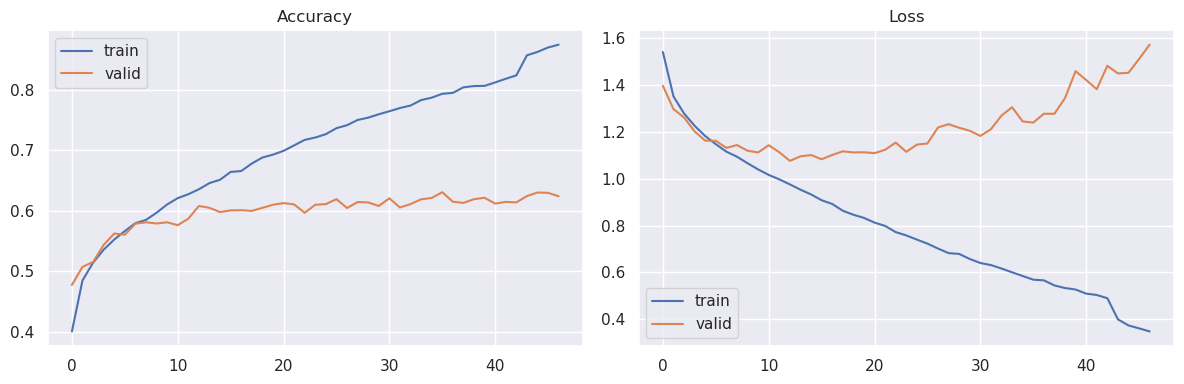

In [23]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


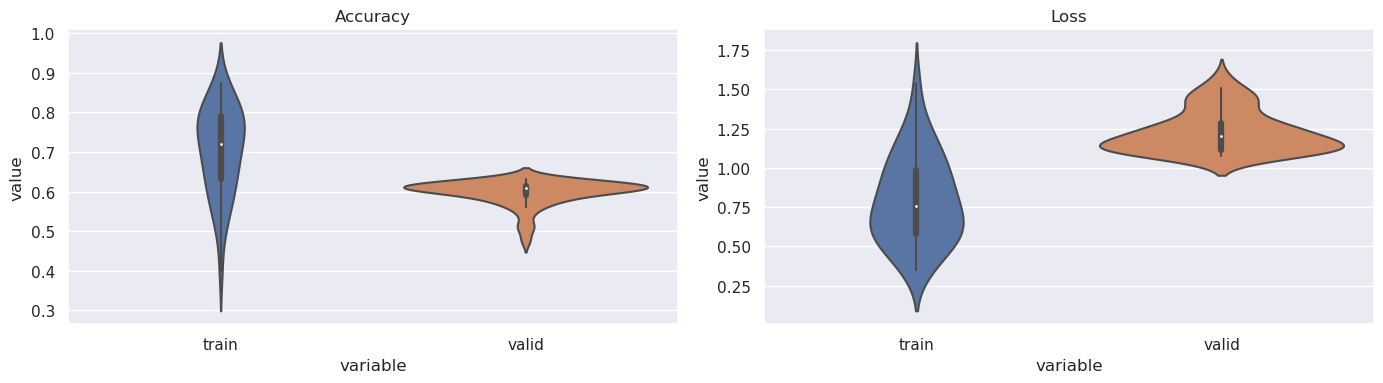

In [24]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

This is for testing data
113/113 [==============================] - 1s 10ms/step
total wrong testing predictions: 1336


              precision    recall  f1-score   support

           0     0.5462    0.5616    0.5538       495
           1     0.7632    0.5273    0.6237        55
           2     0.5012    0.4160    0.4546       512
           3     0.8187    0.7887    0.8034       899
           4     0.5436    0.4918    0.5164       608
           5     0.7368    0.7700    0.7531       400
           6     0.5326    0.6726    0.5944       620

    accuracy                         0.6278      3589
   macro avg     0.6346    0.6040    0.6142      3589
weighted avg     0.6298    0.6278    0.6261      3589



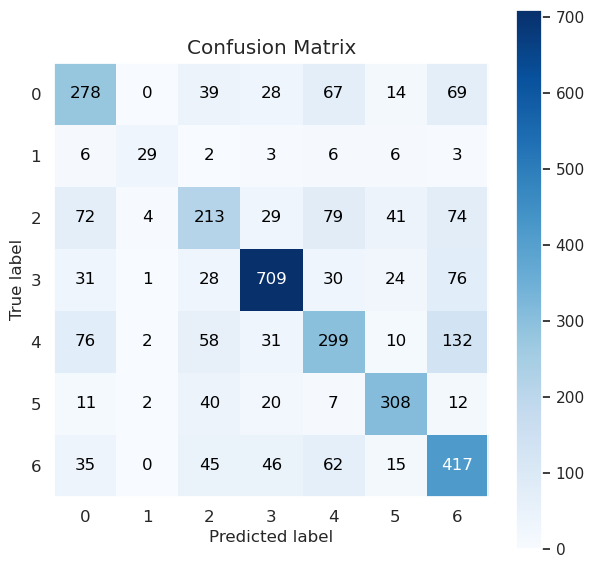

In [25]:
print("This is for testing data")
yhat_test = np.argmax(model.predict(X_test), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong testing predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_test)}\n\n')
report = classification_report(np.argmax(y_test, axis=1), yhat_test, digits=4)
print(report)

this is for validationd data
112/112 [==============================] - 1s 8ms/step
total wrong validation predictions: 1313


              precision    recall  f1-score   support

           0     0.5462    0.5616    0.5538       495
           1     0.7632    0.5273    0.6237        55
           2     0.5012    0.4160    0.4546       512
           3     0.8187    0.7887    0.8034       899
           4     0.5436    0.4918    0.5164       608
           5     0.7368    0.7700    0.7531       400
           6     0.5326    0.6726    0.5944       620

    accuracy                         0.6278      3589
   macro avg     0.6346    0.6040    0.6142      3589
weighted avg     0.6298    0.6278    0.6261      3589



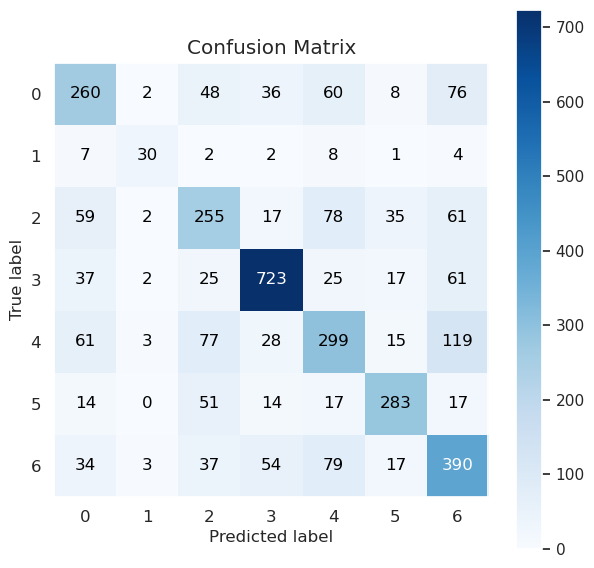

In [26]:
print("this is for validationd data")
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
report = classification_report(np.argmax(y_test, axis=1), yhat_test, digits=4)
print(report)